# Tutorial 1 - KERAS DNN Classification

We will predict the price category, among 4 categories, of an AIRBNB listing (`price_category` column). This is a multi-class classification task.

**The unit of analysis is an AIRBNB LISTING**

# Setup

In [15]:
# Common imports
import numpy as np
import pandas as pd

np.random.seed(42)


# Get the data

In [16]:
#We will predict the "price_gte_150" value in the data set:

airbnb = pd.read_csv("airbnb.csv")
airbnb.head()

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,guests_included,price_per_extra_person,minimum_nights,number_of_reviews,number_days_btw_first_last_review,review_scores_rating,cancellation_policy,price,price_gte_150,price_category
0,0,0,Roslindale,42.282619,-71.133068,House,Entire home/apt,4,1.5,2.0,...,1,0,2,0,0,NaN,moderate,250,1,gte_226
1,0,1,Roslindale,42.286241,-71.134374,Apartment,Private room,2,1.0,1.0,...,0,0,2,36,804,94.0,moderate,65,0,lte_75
2,1,1,Roslindale,42.292438,-71.135765,Apartment,Private room,2,1.0,1.0,...,1,20,3,41,2574,98.0,moderate,65,0,lte_75
3,0,0,Roslindale,42.281106,-71.121021,House,Private room,4,1.0,1.0,...,2,25,1,1,0,100.0,moderate,75,0,lte_75
4,1,1,Roslindale,42.284512,-71.136258,House,Private room,2,1.5,1.0,...,1,0,2,29,380,99.0,flexible,79,0,btw_75-150


# Split the data into train and test

In [17]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(airbnb, test_size=0.3)

### Be careful: we haven't seperated the target column yet

## Check the missing values

In [18]:
train_set.isna().sum()

host_is_superhost                       0
host_identity_verified                  0
neighbourhood_cleansed                  0
latitude                                0
longitude                               0
property_type                           8
room_type                               0
accommodates                            0
bathrooms                              19
bedrooms                               19
beds                                   16
bed_type                                0
Number of amenities                     0
guests_included                         0
price_per_extra_person                  0
minimum_nights                          0
number_of_reviews                       0
number_days_btw_first_last_review       0
review_scores_rating                 1609
cancellation_policy                     0
price                                   0
price_gte_150                           0
price_category                          0
dtype: int64

In [19]:
test_set.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          1
room_type                              0
accommodates                           0
bathrooms                             17
bedrooms                              11
beds                                   8
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 674
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

# Data Prep

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

## Drop the variables we can't use in this tutorial

In [21]:
# We can't use the following columns in this tutorial, because they are not for binary classification tasks

train = train_set.drop(['price', 'price_gte_150'], axis=1)
test = test_set.drop(['price', 'price_gte_150'], axis=1)

## Separate the target variable (we don't want to transform it)

In [22]:
train_target = train[['price_category']]
test_target = test[['price_category']]

train_inputs = train.drop(['price_category'], axis=1)
test_inputs = test.drop(['price_category'], axis=1)

## Feature Engineering: Let's derive a new column

#### Remember, the "minimum_nights" column is highly skewed. Let's try to transform it. 

In [23]:
train_inputs['minimum_nights'].value_counts()

1      2901
2      1980
3      1220
7       254
4       239
5       185
10      144
30       57
14       50
15       43
6        35
20       15
28       13
32        9
25        8
60        6
90        5
27        4
9         4
17        3
13        3
23        3
8         2
21        2
11        2
273       2
18        1
Name: minimum_nights, dtype: int64

<AxesSubplot:>

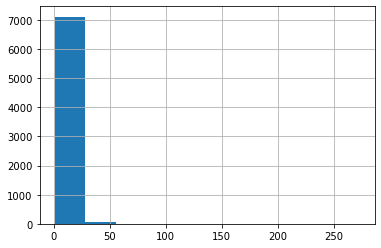

In [24]:
train_inputs['minimum_nights'].hist()

In [25]:
# Import power transformer from sklearn. It will help us create a "normal distribution"
from sklearn.preprocessing import PowerTransformer

PT = PowerTransformer(method = 'yeo-johnson', standardize=True)

In [26]:
transformed_min_nights = PT.fit_transform(train_inputs[['minimum_nights']])

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

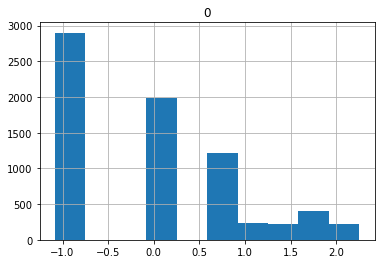

In [27]:
pd.DataFrame(transformed_min_nights).hist()

NOTE1: We didn't make the transformed variable as part of the input variables yet. To do that, we will use the pipeline.

NOTE2: We don't need to create a function (like before). This transformer already has fit() and transform(). So, we can use this in the pipeline.

##  Identify the numerical and categorical columns

In [28]:
train_inputs.dtypes

host_is_superhost                      int64
host_identity_verified                 int64
neighbourhood_cleansed                object
latitude                             float64
longitude                            float64
property_type                         object
room_type                             object
accommodates                           int64
bathrooms                            float64
bedrooms                             float64
beds                                 float64
bed_type                              object
Number of amenities                    int64
guests_included                        int64
price_per_extra_person                 int64
minimum_nights                         int64
number_of_reviews                      int64
number_days_btw_first_last_review      int64
review_scores_rating                 float64
cancellation_policy                   object
dtype: object

**At this stage, you can manually identify numeric, binary, and categorical columns as follows:**

`numeric_columns = ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'Number of amenities', 'guests_included', 'price_per_extra_person', 'minimum_nights', 'number_of_reviews', 'number_days_btw_first_last_review', 'review_scores_rating']`
 
 `binary_columns = ['host_is_superhost', 'host_identity_verified']`
 
 `categorical_columns = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']`
 
<br>
 
**If you do not want to manually type these, you can do the below tricks:**

In [29]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [30]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = ['host_is_superhost', 'host_identity_verified']

In [31]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

In [32]:
binary_columns

['host_is_superhost', 'host_identity_verified']

In [33]:
numeric_columns

['latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'Number of amenities',
 'guests_included',
 'price_per_extra_person',
 'minimum_nights',
 'number_of_reviews',
 'number_days_btw_first_last_review',
 'review_scores_rating']

In [34]:
categorical_columns

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

In [35]:
transformed_columns = ['minimum_nights']

# Pipeline

In [36]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [37]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [38]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [39]:
my_new_column = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('powertransformer', PowerTransformer(method = 'yeo-johnson', standardize=True))])

In [40]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, transformed_columns)],
        remainder='passthrough')

#passtrough is an optional step. You don't have to use it.

# Transform: fit_transform() for TRAIN

In [41]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

array([[-2.10940159, -1.39824237,  1.20477863, ...,  0.        ,
         1.        ,  0.21001201],
       [ 0.61906783, -1.38593382, -1.16133947, ...,  0.        ,
         0.        ,  2.02534721],
       [ 0.14448465, -0.16705969, -1.16133947, ...,  0.        ,
         1.        ,  0.21001201],
       ...,
       [ 0.82039585,  0.74441303, -0.56980994, ...,  0.        ,
         0.        ,  1.372366  ],
       [-0.92762441,  0.3821493 , -0.56980994, ...,  0.        ,
         1.        , -1.08388465],
       [-0.34071414, -0.53929512, -1.16133947, ...,  0.        ,
         0.        , -1.08388465]])

In [42]:
train_x.shape

(7190, 62)

# Tranform: transform() for TEST

In [43]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

array([[ 0.63069768,  0.40533687,  1.79630816, ...,  0.        ,
         1.        ,  0.81147266],
       [ 0.15153485,  0.27611111, -0.56980994, ...,  0.        ,
         1.        ,  1.63309414],
       [-2.02789334, -0.91924215,  0.02171958, ...,  0.        ,
         1.        ,  0.21001201],
       ...,
       [ 0.15906806, -0.38872897,  1.20477863, ...,  0.        ,
         1.        ,  0.81147266],
       [ 0.11838687, -0.56878308, -0.56980994, ...,  0.        ,
         0.        , -1.08388465],
       [-0.94171792,  0.19283558, -1.16133947, ...,  0.        ,
         1.        ,  2.13904414]])

In [44]:
test_x.shape

(3082, 62)

In [45]:
train_target

,price_category
3437,btw_75-150
6622,lte_75
2262,btw_75-150
2246,btw_75-150
835,gte_226
...,...
5734,gte_226
5191,btw_75-150
5390,gte_226
860,btw_75-150


# Keras needs Ordinal target values for classification

In [46]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()

train_y = ord_enc.fit_transform(train_target)

train_y

array([[1.],
       [3.],
       [1.],
       ...,
       [2.],
       [1.],
       [3.]])

In [47]:
test_y = ord_enc.transform(test_target)

test_y

array([[2.],
       [1.],
       [3.],
       ...,
       [2.],
       [3.],
       [3.]])

In [48]:
ord_enc.categories_

[array(['btw_151-225', 'btw_75-150', 'gte_226', 'lte_75'], dtype=object)]

# Baseline

In [49]:
train_target.value_counts()/len(train_target)

price_category
btw_75-150        0.332823
btw_151-225       0.241725
lte_75            0.214743
gte_226           0.210709
dtype: float64

# Multiclass classification using Keras



In [50]:
import tensorflow as tf
from tensorflow import keras

# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [51]:
#What is your input shape?
#(meaning: how many neurons should be in the input layer?)

train_x.shape

(7190, 62)

In [52]:
#Define the model: for multi-class

model = keras.models.Sequential()

model.add(keras.layers.Input(shape=62)) #match nerons with column count or train shape (train_x.shape[1])
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))

#final layer: there has to be 4 nodes with softmax (because we have 4 categories)
model.add(keras.layers.Dense(4, activation='softmax'))


In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               6300      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 404       
Total params: 26,904
Trainable params: 26,904
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Compile model

#Optimizer:
adam = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

## Ordinal target (as in this example):

Final layer's activation = **softmax** <br>
loss = **sparse_categorical_crossentropy**

## One-hot target

Final layer's activation = **softmax** <br>
loss = **categorical_crossentropy**

## Binary target 

Final layer has only 1 neuron <br>
Final layer's activation = **sigmoid** <br>
loss = **binary_crossentropy**

## Regression task (target is continuous)

Final layer has only 1 neuron (keras.layers.Dense(1))<br>
Activation is None<br>
loss = **mean_squared_error**


In [55]:
# Fit the model

history = model.fit(train_x, train_y, 
                    validation_data=(test_x, test_y), 
                    epochs=20, batch_size=500)

Epoch 1/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0045 - accuracy: 0.5257 - val_loss: 0.8349 - val_accuracy: 0.6275
Epoch 2/20
15/15 [==============================] - 0s 2ms/step - loss: 0.7914 - accuracy: 0.6362 - val_loss: 0.7827 - val_accuracy: 0.6437
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 0.7201 - accuracy: 0.6673 - val_loss: 0.7264 - val_accuracy: 0.6775
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.7088 - val_loss: 0.7129 - val_accuracy: 0.6944
Epoch 5/20
15/15 [==============================] - 0s 2ms/step - loss: 0.6035 - accuracy: 0.7337 - val_loss: 0.6472 - val_accuracy: 0.7236
Epoch 6/20
15/15 [==============================] - 0s 2ms/step - loss: 0.5654 - accuracy: 0.7537 - val_loss: 0.6258 - val_accuracy: 0.7424
Epoch 7/20
15/15 [==============================] - 0s 2ms/step - loss: 0.4889 - accuracy: 0.7922 - val_loss: 0.5736 - val_accuracy: 0.7657
Epoch 8/20
15/15 [==

In [56]:
# evaluate the model

scores = model.evaluate(test_x, test_y, verbose=0)

scores

# In results, first is loss, second is accuracy

[0.34639641642570496, 0.9130434989929199]

In [57]:
# extract the accuracy from model.evaluate

print("%s: %.2f" % (model.metrics_names[0], scores[0]))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


loss: 0.35
accuracy: 91.30%


# Wide & Deep Network

## Let's send all inputs to the last layer

In [58]:
model = keras.models.Sequential()


inputlayer = keras.layers.Input(shape=62)

hidden1 = keras.layers.Dense(100, activation='relu')(inputlayer)
hidden2 = keras.layers.Dense(100, activation='relu')(hidden1)
hidden3 = keras.layers.Dense(100, activation='relu')(hidden2)

concat = keras.layers.Concatenate()([inputlayer, hidden3])

#final layer: there has to be 4 nodes with softmax (because we have 4 categories)
output = keras.layers.Dense(4, activation='softmax')(concat)

model = keras.Model(inputs =[inputlayer], outputs = output)


In [59]:
# Compile model

#Optimizer:

adam = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [60]:
# Fit the model

history = model.fit(train_x, train_y, 
                    validation_data=(test_x, test_y), 
                    epochs=20, batch_size=500)

Epoch 1/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0153 - accuracy: 0.5170 - val_loss: 0.8469 - val_accuracy: 0.6087
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 0.7976 - accuracy: 0.6360 - val_loss: 0.7898 - val_accuracy: 0.6402
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 0.7261 - accuracy: 0.6734 - val_loss: 0.7297 - val_accuracy: 0.6781
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.7086 - val_loss: 0.7268 - val_accuracy: 0.6924
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6088 - accuracy: 0.7309 - val_loss: 0.6719 - val_accuracy: 0.6992
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 0.5556 - accuracy: 0.7627 - val_loss: 0.6133 - val_accuracy: 0.7489
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 0.4849 - accuracy: 0.7987 - val_loss: 0.5788 - val_accuracy: 0.7716
Epoch 8/20
15/15 [==

In [61]:
# evaluate the model

scores = model.evaluate(test_x, test_y, verbose=0)

scores

# In results, first is loss, second is accuracy

[0.39345189929008484, 0.907852053642273]

In [62]:
# extract the accuracy from model.evaluate

print("%s: %.2f" % (model.metrics_names[0], scores[0]))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


loss: 0.39
accuracy: 90.79%


## Let's send two inputs to the last layer

In [63]:
# Select the first two columns: longitude and latitude
#(WHY: because lat and lon are good and important predictors)

lon_lat = train_x[:,:2]

lon_lat

array([[-2.10940159, -1.39824237],
       [ 0.61906783, -1.38593382],
       [ 0.14448465, -0.16705969],
       ...,
       [ 0.82039585,  0.74441303],
       [-0.92762441,  0.3821493 ],
       [-0.34071414, -0.53929512]])

In [64]:
model = keras.models.Sequential()

input1 = keras.layers.Input(shape=2)
input2 = keras.layers.Input(shape=62)

hidden1 = keras.layers.Dense(100, activation='relu')(input2)
hidden2 = keras.layers.Dense(100, activation='relu')(hidden1)
hidden3 = keras.layers.Dense(100, activation='relu')(hidden2)

concat = keras.layers.Concatenate()([input1, hidden3])

#final layer: there has to be 4 nodes with softmax (because we have 4 categories)
output = keras.layers.Dense(4, activation='softmax')(concat)

model = keras.Model(inputs =[input1, input2], outputs = output)

In [65]:
# Compile model

#Optimizer:
adam = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [66]:
# Fit the model

history = model.fit((lon_lat, train_x), train_y, 
                    validation_data=((test_x[:,:2], test_x), test_y), 
                    epochs=20, batch_size=500)

Epoch 1/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0083 - accuracy: 0.5285 - val_loss: 0.8429 - val_accuracy: 0.6142
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 0.7968 - accuracy: 0.6307 - val_loss: 0.7881 - val_accuracy: 0.6531
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 0.7312 - accuracy: 0.6658 - val_loss: 0.7440 - val_accuracy: 0.6690
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.7015 - val_loss: 0.7103 - val_accuracy: 0.7021
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 0.5984 - accuracy: 0.7387 - val_loss: 0.6693 - val_accuracy: 0.7187
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 0.5235 - accuracy: 0.7830 - val_loss: 0.5849 - val_accuracy: 0.7573
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 0.4414 - accuracy: 0.8210 - val_loss: 0.5784 - val_accuracy: 0.7592
Epoch 8/20
15/15 [==

In [67]:
# evaluate the model

scores = model.evaluate((test_x[:,:2], test_x), test_y, verbose=0)

scores

# In results, first is loss, second is accuracy

[0.3454035818576813, 0.9127190113067627]

In [68]:
# extract the accuracy from model.evaluate

print("%s: %.2f" % (model.metrics_names[0], scores[0]))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

loss: 0.35
accuracy: 91.27%


# Optimizers, Learning rate, Dropout, Initialization & Activation functions

In [69]:
#Define the model: for multi-class


#Set the learning rate:
lr=0.001


#Available optimizers:
adagrad = keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=0.0)
sgd = keras.optimizers.SGD(lr=lr, momentum=0.0, decay=0.0, nesterov=False)
rmsprop = keras.optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0)
adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
nesterov_adam = keras.optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

#Initializations:
xavier = keras.initializers.glorot_normal(seed=None)
he = keras.initializers.he_normal(seed=None)


# Activation functions. Uncomment only one
activation = 'elu' 
#activation = 'relu'
#activation = 'tanh'
#activation = 'sigmoid'



#See the droput layers below:
input1 = keras.layers.Input(shape=62)

hidden1 = keras.layers.Dense(100, activation=activation, kernel_initializer=xavier)(input1)
drop1   = keras.layers.Dropout(0.2)(hidden1)
hidden2 = keras.layers.Dense(100, activation=activation, kernel_initializer=xavier)(drop1)
drop2   = keras.layers.Dropout(0.2)(hidden2)
hidden3 = keras.layers.Dense(100, activation=activation, kernel_initializer=xavier)(drop2)

#final layer: there has to be 4 nodes with softmax (because we have 4 categories)
output = keras.layers.Dense(4, activation='softmax')(hidden3)

#Compile"
model = keras.Model(inputs = input1, outputs = output)

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=nesterov_adam, metrics=['accuracy'])

C:\Users\erich\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [70]:
# Fit the model

history = model.fit(train_x, train_y, 
                    validation_data=(test_x, test_y), 
                    epochs=20, batch_size=500)



Epoch 1/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1789 - accuracy: 0.4497 - val_loss: 0.9798 - val_accuracy: 0.5448
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 0.9723 - accuracy: 0.5476 - val_loss: 0.9026 - val_accuracy: 0.5886
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 0.9281 - accuracy: 0.5723 - val_loss: 0.8707 - val_accuracy: 0.6074
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 0.8909 - accuracy: 0.5858 - val_loss: 0.8540 - val_accuracy: 0.6155
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 0.8830 - accuracy: 0.6000 - val_loss: 0.8417 - val_accuracy: 0.6165
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 0.8663 - accuracy: 0.6049 - val_loss: 0.8408 - val_accuracy: 0.6213
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 0.8590 - accuracy: 0.6078 - val_loss: 0.8262 - val_accuracy: 0.6317
Epoch 8/20
15/15 [==

In [71]:
# evaluate the model

scores = model.evaluate(test_x, test_y, verbose=0)

scores

# In results, first is loss, second is accuracy

[0.7877442240715027, 0.6534717679023743]

In [72]:
# extract the accuracy from model.evaluate

print("%s: %.2f" % (model.metrics_names[0], scores[0]))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


loss: 0.79
accuracy: 65.35%


# Early stopping based on validation results

To do this, you need to send the validation data sets to the fit() function and use a callback.

EarlyStopping Arguments:

**monitor:** quantity to be monitored.<br>
**min_delta:** minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.<br>
**patience:** number of epochs with no improvement after which training will be stopped.<br>
**verbose:** verbosity mode.<br>
**mode:** one of {auto, min, max}. In min mode, training will stop when the quantity monitored has stopped decreasing; in max mode it will stop when the quantity monitored has stopped increasing; in auto mode, the direction is automatically inferred from the name of the monitored quantity.<br>
**baseline:** Baseline value for the monitored quantity to reach. Training will stop if the model doesn't show improvement over the baseline.<br>
**restore_best_weights:** whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

callback = [earlystop]

model.fit(train_x, train_y, validation_data=(test_x, test_y), 
          epochs=100, batch_size=500, callbacks=callback)

# Grid Search

In [ ]:
def build_model(n_hidden=3, n_neurons=100, learning_rate=3e-3, act="relu"):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=62))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=act))
    model.add(keras.layers.Dense(4, activation='softmax'))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model)

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

callback = [earlystop]

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
                "n_hidden": (1,2,3,4,5), #np.arange(1, 5), generates error because of a scikit bug
                "n_neurons": (50,55,60,65,70,75,80,85,90,95,100), #np.arange(50, 100), generates error
                "learning_rate": (0.001, 0.01, 0.1)
                }

rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter=5, cv=3)

rnd_search_cv.fit(train_x, train_y, epochs=5, validation_data=(test_x, test_y), 
                  callbacks=callback, verbose=0)


In [ ]:
rnd_search_cv.best_params_